In [38]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import csv
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [39]:
# Define the custom dataset class for Kuzushiji-49 images
class Kuzushiji49Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Apply transformation, including converting to PIL image if needed for PyTorch transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),    # Convert PIL Image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images
])

# Load data from the .npz files
train_images_file = r"C:\Users\kober\School Work\MQP\k49 dataset\k49-train-imgs.npz"
train_labels_file = r"C:\Users\kober\School Work\MQP\k49 dataset\k49-train-labels.npz"
test_images_file = r"C:\Users\kober\School Work\MQP\k49 dataset\k49-test-imgs.npz"
test_labels_file = r"C:\Users\kober\School Work\MQP\k49 dataset\k49-test-labels.npz"

# Inspect the contents of the .npz files to find the correct keys
train_images_data = np.load(train_images_file)
train_labels_data = np.load(train_labels_file)
test_images_data = np.load(test_images_file)
test_labels_data = np.load(test_labels_file)

# Extract images and labels using the correct keys (replace 'arr_0' with actual keys found)
train_images = train_images_data['arr_0']
train_labels = train_labels_data['arr_0']
test_images = test_images_data['arr_0']
test_labels = test_labels_data['arr_0']

# Create dataset instances
train_dataset = Kuzushiji49Dataset(train_images, train_labels, transform=transform)
test_dataset = Kuzushiji49Dataset(test_images, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [40]:
# 3-layer CNN model
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 18, kernel_size=7, padding=3),  # First Conv layer
            nn.BatchNorm2d(18),  # Batch Normalization
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Max Pooling

            nn.Conv2d(18, 38, kernel_size=5, padding=2),  # Second Conv layer
            nn.BatchNorm2d(38),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(38, 70, kernel_size=4, padding=1),  # Third Conv layer
            nn.BatchNorm2d(70),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),  # Flatten layer
            nn.Linear(70 * 3 * 3, 30),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer to reduce overfitting
            nn.Linear(30, 49),  # Output layer for 49 classes
            nn.Softmax(dim=1)  # Softmax activation for classification
        )

    def forward(self, x):
        return self.model(x)

# 4-layer CNN model
class CNN4(nn.Module):
    def __init__(self):
        super(CNN4, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 18, kernel_size=5, padding=3),  # First Conv layer
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(18, 38, kernel_size=5, padding=3),  # Second Conv layer
            nn.BatchNorm2d(38),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(38, 70, kernel_size=4, padding=2),  # Third Conv layer
            nn.BatchNorm2d(70),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(70, 128, kernel_size=3, padding=2),  # Fourth Conv layer
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),  # Flatten layer
            nn.Linear(128 * 3 * 3, 30),  # Fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer to reduce overfitting
            nn.Linear(30, 49),  # Output layer for 49 classes
            nn.Softmax(dim=1)  # Softmax activation for classification
        )

    def forward(self, x):
        return self.model(x)

In [41]:
criterion = nn.CrossEntropyLoss()

# Training the model
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test_and_save_misclassifications(model, device, test_loader, csv_filename, num_misclassified_to_show=25):
    model.eval()
    all_predictions = []
    all_ground_truths = []
    all_probabilities = []
    correct_classifications = []
    incorrect_classifications = []
    misclassified_images = []
    misclassified_preds = []
    misclassified_targets = []
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Get the predicted label and probabilities
            pred = output.argmax(dim=1, keepdim=True)
            probabilities = output.max(dim=1)[0]  # Get the probability of the predicted label
            
            # Store the predictions and ground truth labels
            all_predictions.extend(pred.cpu().numpy())
            all_ground_truths.extend(target.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

            # Check for misclassifications
            misclassified_indices = pred.view(-1) != target.view(-1)
            correct_indices = pred.view(-1) == target.view(-1)
            
            # Add correct and incorrect classifications to their respective lists
            correct_classifications.extend([(gt.item(), pred.item(), True) for gt, pred in zip(target[correct_indices], pred[correct_indices])])
            incorrect_classifications.extend([(gt.item(), pred.item(), False) for gt, pred in zip(target[misclassified_indices], pred[misclassified_indices])])

            # Add misclassified images for visualization
            misclassified_images.extend(data[misclassified_indices].cpu())
            misclassified_preds.extend(pred[misclassified_indices].cpu().numpy())
            misclassified_targets.extend(target[misclassified_indices].cpu().numpy())
            
            # Calculate the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    # Calculate accuracy
    accuracy = 100. * correct / total
    num_misclassifications = len(misclassified_images)
    
    # Output the number of misclassifications and test accuracy
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Total Misclassifications: {num_misclassifications}')

    # Save the correct and incorrect classifications to a CSV file
    save_classifications_to_csv(csv_filename, correct_classifications, incorrect_classifications)

    # Visualize the misclassified images
    plot_misclassified_images(misclassified_images, misclassified_preds, misclassified_targets, num_misclassified_to_show)

# Save classifications (correct and incorrect) to CSV
def save_classifications_to_csv(file_name, correct_classifications, incorrect_classifications):
    with open(file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Ground Truth", "Predicted Label", "Correct Classification"])
        
        # Write correct classifications
        for gt, pred, correct in correct_classifications:
            writer.writerow([gt, pred, correct])

        # Write incorrect classifications
        for gt, pred, correct in incorrect_classifications:
            writer.writerow([gt, pred, correct])

# Plot misclassified images, configurable for how many to show
def plot_misclassified_images(images, predictions, ground_truths, num_to_show):
    fig, axes = plt.subplots(nrows=(num_to_show // 5), ncols=5, figsize=(15, num_to_show // 5 * 3))
    axes = axes.flatten()

    for i in range(min(num_to_show, len(images))):  # Display at most 'num_to_show' misclassified images
        image = images[i].numpy().squeeze()
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"True: {ground_truths[i]}, Pred: {predictions[i]}")
        axes[i].axis('off')

    # Hide any unused axes
    for ax in axes[i + 1:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training the 3-layer model...
Train Epoch: 1 [0/232365 (0%)]	Loss: 3.890557
Train Epoch: 1 [6400/232365 (3%)]	Loss: 3.742252
Train Epoch: 1 [12800/232365 (6%)]	Loss: 3.821042
Train Epoch: 1 [19200/232365 (8%)]	Loss: 3.751063
Train Epoch: 1 [25600/232365 (11%)]	Loss: 3.791543
Train Epoch: 1 [32000/232365 (14%)]	Loss: 3.770462
Train Epoch: 1 [38400/232365 (17%)]	Loss: 3.738210
Train Epoch: 1 [44800/232365 (19%)]	Loss: 3.715014
Train Epoch: 1 [51200/232365 (22%)]	Loss: 3.762948
Train Epoch: 1 [57600/232365 (25%)]	Loss: 3.730609
Train Epoch: 1 [64000/232365 (28%)]	Loss: 3.683105
Train Epoch: 1 [70400/232365 (30%)]	Loss: 3.783337
Train Epoch: 1 [76800/232365 (33%)]	Loss: 3.717770
Train Epoch: 1 [83200/232365 (36%)]	Loss: 3.722034
Train Epoch: 1 [89600/232365 (39%)]	Loss: 3.738592
Train Epoch: 1 [96000/232365 (41%)]	Loss: 3.675468
Train Epoch: 1 [102400/232365 (44%)]	Loss: 3.648019
Train Epoch: 1 [108800/232365 (47%)]	Loss: 3.609978
Train Epoch: 1 [115200/232365 (50%)]	Loss: 3.666258
Train E

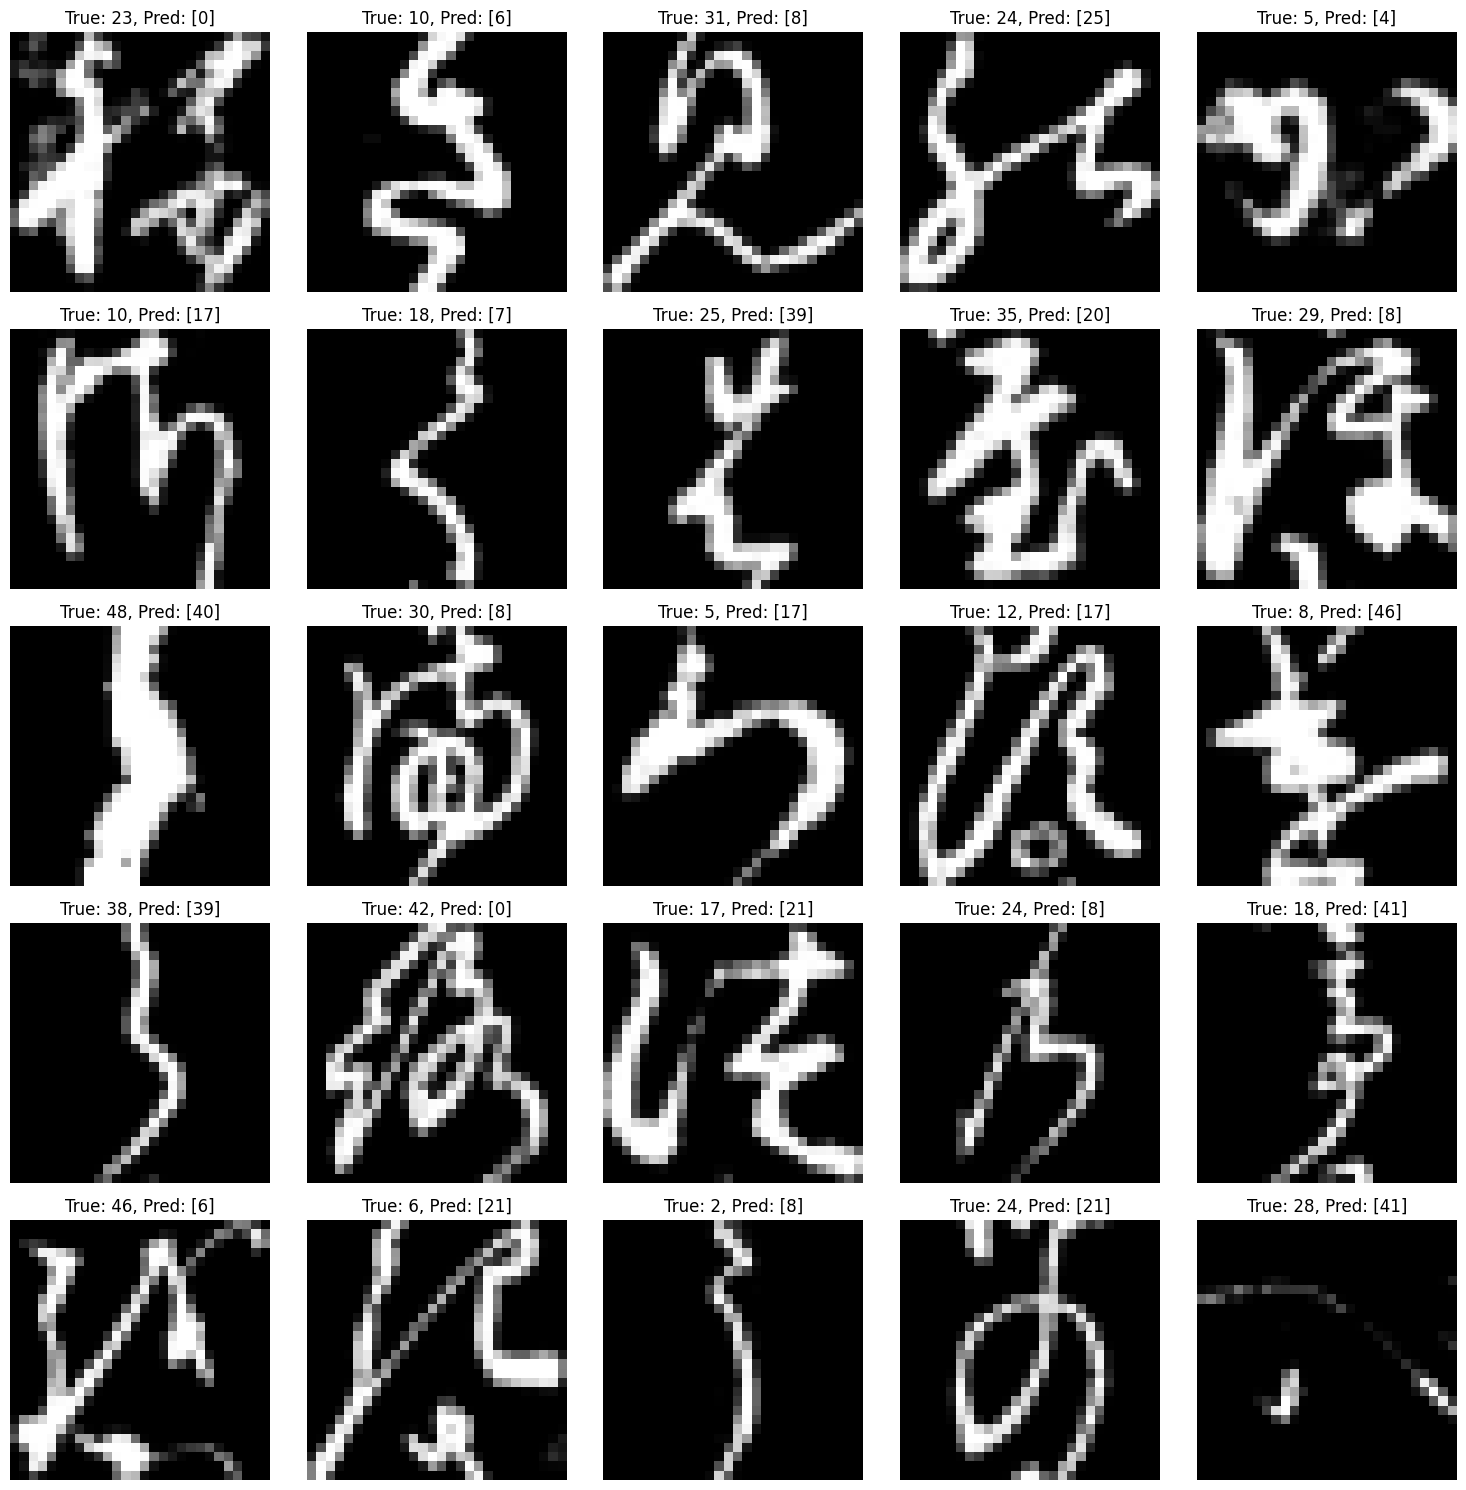

In [42]:
# 3-layer CNN model
model_3_layer = CNN3().to(device)
optimizer_3_layer = optim.RMSprop(model_3_layer.parameters(), lr=0.001)

# Train for 10 epochs
print("Training the 3-layer model...")
for epoch in range(1, 11):
    train(model_3_layer, device, train_loader, optimizer_3_layer, epoch)

# Test and save misclassifications for 3-layer CNN model
print("\nTesting the 3-layer model and displaying misclassifications...")
test_and_save_misclassifications(model_3_layer, device, test_loader, "Kuzushiji_classifications_3_layer.csv", num_misclassified_to_show=25)

Training the 4-layer model...
Train Epoch: 1 [0/232365 (0%)]	Loss: 3.891212
Train Epoch: 1 [6400/232365 (3%)]	Loss: 3.792458
Train Epoch: 1 [12800/232365 (6%)]	Loss: 3.888089
Train Epoch: 1 [19200/232365 (8%)]	Loss: 3.854929
Train Epoch: 1 [25600/232365 (11%)]	Loss: 3.784927
Train Epoch: 1 [32000/232365 (14%)]	Loss: 3.791223
Train Epoch: 1 [38400/232365 (17%)]	Loss: 3.772720
Train Epoch: 1 [44800/232365 (19%)]	Loss: 3.784914
Train Epoch: 1 [51200/232365 (22%)]	Loss: 3.695825
Train Epoch: 1 [57600/232365 (25%)]	Loss: 3.773306
Train Epoch: 1 [64000/232365 (28%)]	Loss: 3.658173
Train Epoch: 1 [70400/232365 (30%)]	Loss: 3.702345
Train Epoch: 1 [76800/232365 (33%)]	Loss: 3.754032
Train Epoch: 1 [83200/232365 (36%)]	Loss: 3.739462
Train Epoch: 1 [89600/232365 (39%)]	Loss: 3.728334
Train Epoch: 1 [96000/232365 (41%)]	Loss: 3.734974
Train Epoch: 1 [102400/232365 (44%)]	Loss: 3.750683
Train Epoch: 1 [108800/232365 (47%)]	Loss: 3.717329
Train Epoch: 1 [115200/232365 (50%)]	Loss: 3.670417
Train E

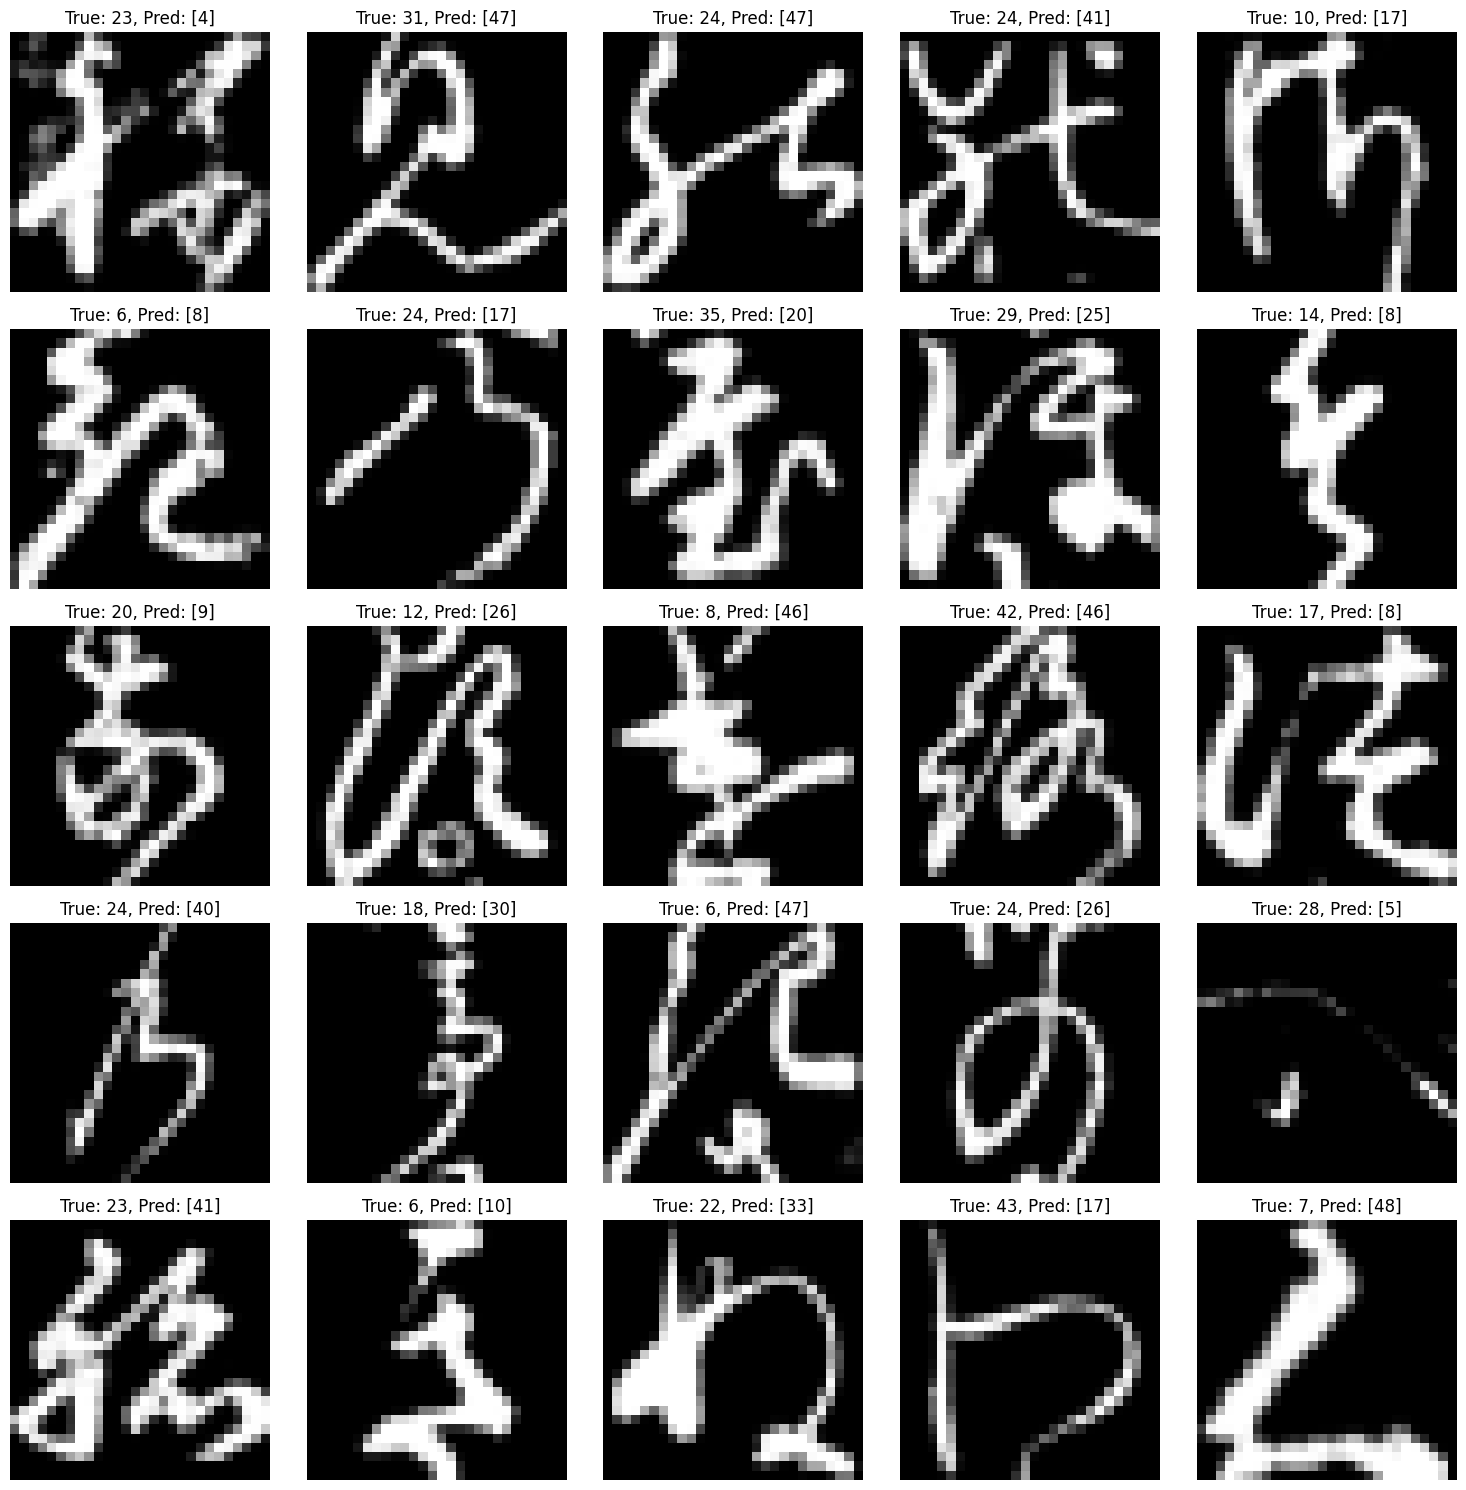

In [43]:
# 4-layer CNN model
model_4_layer = CNN4().to(device)
optimizer_4_layer = optim.RMSprop(model_4_layer.parameters(), lr=0.001)

# Train for 10 epochs
print("Training the 4-layer model...")
for epoch in range(1, 11):
    train(model_4_layer, device, train_loader, optimizer_4_layer, epoch)

# Test and save misclassifications for 4-layer CNN model
print("\nTesting the 4-layer model and displaying misclassifications...")
test_and_save_misclassifications(model_4_layer, device, test_loader, "Kuzushiji_classifications_4_layer.csv", num_misclassified_to_show=25)

In [44]:
# Flatten and normalize images for softmax regression
train_images_flat = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images_flat = test_images.reshape(test_images.shape[0], -1) / 255.0

# Softmax regression model for logistic regression
def run_softmax_regression(X_train, y_train, X_test, y_test, output_csv):
    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Softmax Regression Test Accuracy: {accuracy * 100:.2f}%")
    save_softmax_probabilities(model, X_test, output_csv)

def save_softmax_probabilities(model, X_test, output_csv):
    softmax_probs = model.predict_proba(X_test)
    df = pd.DataFrame(softmax_probs, columns=[f'Class_{i}' for i in range(softmax_probs.shape[1])])
    df['Row_Sum'] = df.sum(axis=1)
    df.to_csv(output_csv, index=False)
    print(f"Softmax probabilities saved to {output_csv}")

# Run softmax regression on Kuzushiji-49 data
run_softmax_regression(train_images_flat, train_labels, test_images_flat, test_labels, "Kuzushiji_softmax_output_kuzushiji49.csv")


Softmax Regression Test Accuracy: 57.38%
Softmax probabilities saved to Kuzushiji_softmax_output_kuzushiji49.csv
